# Phishing URL Detection

### Initialisation

In [1]:
import pandas as pd
df = pd.read_csv('dataset.csv')
df.sample(5)

,URL,Label
23552,helpinghandresearch.com/~purebusi/paypal/,bad
325846,facebook.com/Dexter.L.H.Tan,good
11102,www.cheappropertyspecials.com/_private/remaxpr...,bad
312053,dailymotion.com/video/xm813g_council-3rd-ward_...,good
112264,importarmas.com/modules/mod_banners/logon.do.php,bad


### Description

In [2]:
df.describe()

,URL,Label
count,549346,549346
unique,507195,2
top,jhomitevd2abj3fk.tor2web.org/,good
freq,52,392924


### Remove Duplicates

In [3]:
df.drop_duplicates(inplace=True)
df.shape

(507196, 2)

### Remove Missing Values

In [4]:
df.isnull().sum()

URL      0
Label    0
dtype: int64

### Dataset Information

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 507196 entries, 0 to 516470
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     507196 non-null  object
 1   Label   507196 non-null  object
dtypes: object(2)
memory usage: 11.6+ MB


### Dataset Subset

In [6]:
df = df.sample(200000, random_state=42)

### Preprocessing

In [7]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer

tokenizer = RegexpTokenizer(r'[A-Za-z]+')
stemmer = PorterStemmer()

def tokenize(sentence):
    tokens = tokenizer.tokenize(sentence)
    for token in tokens:
        token = stemmer.stem(token)
    return " ".join(tokens).strip()

df['URL_preprocessed'] = df['URL'].apply(tokenize)
df.head()

,URL,Label,URL_preprocessed
506546,tr7.datahost84.org/rrca.php?id=,bad,tr datahost org rrca php id
128881,samyinayeh.com/login.htm,bad,samyinayeh com login htm
38800,paypal.us.cgi.bin.webscr.cmd.login.webapps.mpp...,bad,paypal us cgi bin webscr cmd login webapps mpp...
17623,phoenixafrica.biz/wp-content/themes/twentyelev...,bad,phoenixafrica biz wp content themes twentyelev...
62284,www.techbomb.com/websafe/,good,www techbomb com websafe


### Vectorizing

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
vectorizer = TfidfVectorizer(max_features=12000,stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(df['URL_preprocessed'])
Y = df['Label']
Y.replace({'bad':0,'good':1},inplace=True)

C:\Users\Rishabh\AppData\Local\Temp\ipykernel_22844\2852462016.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y.replace({'bad':0,'good':1},inplace=True)


### Model Preparation

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

### Model Performance - Multinomial Naive Bayes

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
model = MultinomialNB()
hist = model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88     13628
           1       0.95      0.99      0.97     46372

    accuracy                           0.95     60000
   macro avg       0.95      0.91      0.92     60000
weighted avg       0.95      0.95      0.95     60000



### Model Performance - Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear')
hist = model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.96      0.82      0.89     13628
           1       0.95      0.99      0.97     46372

    accuracy                           0.95     60000
   macro avg       0.95      0.91      0.93     60000
weighted avg       0.95      0.95      0.95     60000



### Model Performance - XGBoost

In [12]:
from xgboost import XGBClassifier
model = XGBClassifier()
hist = model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     13628
           1       0.91      0.99      0.95     46372

    accuracy                           0.92     60000
   macro avg       0.94      0.84      0.88     60000
weighted avg       0.93      0.92      0.92     60000



### Model Performance - ANN

In [13]:
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1, mode='auto', min_delta=0.0001)
X_train = X_train.astype('float32')

model = Sequential()
model.add(Dense(64, input_dim=12000, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(X_train.toarray(), Y_train, epochs=5, batch_size=128, callbacks=[callback], validation_split=0.2)




Epoch 1/5


875/875 [==============================] - 29s 30ms/step - loss: 0.3479 - accuracy: 0.8496 - val_loss: 0.2006 - val_accuracy: 0.9339
Epoch 2/5
875/875 [==============================] - 19s 22ms/step - loss: 0.1544 - accuracy: 0.9474 - val_loss: 0.1373 - val_accuracy: 0.9514
Epoch 3/5
875/875 [==============================] - 19s 21ms/step - loss: 0.1199 - accuracy: 0.9579 - val_loss: 0.1225 - val_accuracy: 0.9547
Epoch 4/5
875/875 [==============================] - 20s 23ms/step - loss: 0.1077 - accuracy: 0.9609 - val_loss: 0.1178 - val_accuracy: 0.9554
Epoch 5/5
875/875 [==============================] - 20s 22ms/step - loss: 0.1012 - accuracy: 0.9623 - val_loss: 0.1155 - val_accuracy: 0.9557


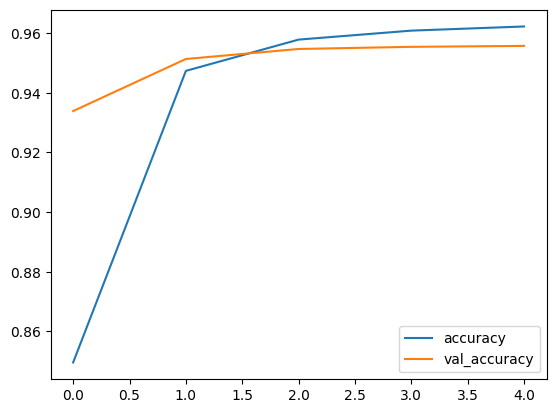

In [16]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='best')
plt.show()

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'],loc='best')
plt.show()

### Pickling

In [ ]:
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)